In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline

In [2]:
train_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"

In [3]:
class FaceDataset(Dataset):
    
    def __init__(self, file_list, dir, transform = None):
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        
        img = self.transform(img)
        img = img.numpy()
            
        return img.astype('float32')

data_transform = transforms.Compose([
    transforms.Resize(66),
    transforms.RandomCrop(64),
    transforms.ToTensor()
])

face_files = os.listdir(train_dir)
face_dataset = FaceDataset(face_files,train_dir,data_transform)

train_dataloader = DataLoader(face_dataset, batch_size = 128,num_workers=4,shuffle=True)

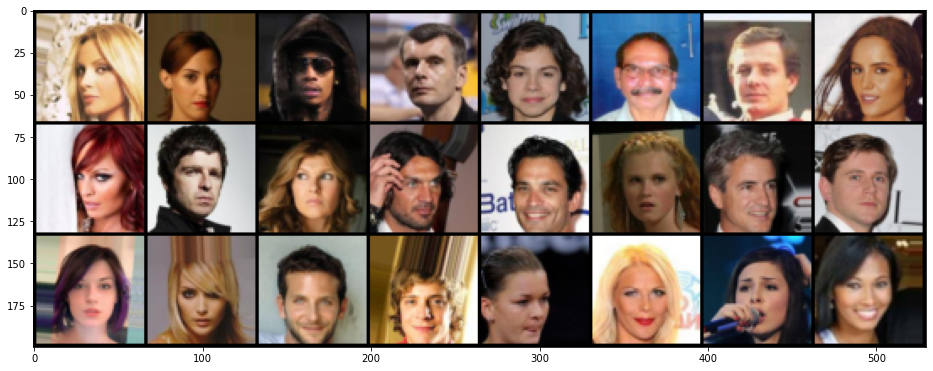

In [4]:
samples = iter(train_dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [5]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100,1024,4,1,0)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024,512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512,256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256,128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128,3, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128,256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256,512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512,1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if True and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

print(generator)
print("")
print(discriminator)

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=

In [8]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Training ...
Batch: 50 Generator Loss: 2.16779065489769 Discriminator Loss: 0.3904289910197258
Batch: 100 Generator Loss: 2.160112944841385 Discriminator Loss: 0.38664417147636415
Batch: 150 Generator Loss: 2.2396241533756256 Discriminator Loss: 0.37762410402297975
Batch: 200 Generator Loss: 2.1562479019165037 Discriminator Loss: 0.3885090774297714
Batch: 250 Generator Loss: 2.136428475379944 Discriminator Loss: 0.38427199244499205
Batch: 300 Generator Loss: 2.2632452094554902 Discriminator Loss: 0.3586008483171463
Batch: 350 Generator Loss: 2.247744867801666 Discriminator Loss: 0.42825615763664243
Batch: 400 Generator Loss: 2.0675307655334474 Discriminator Loss: 0.3740233904123306
Batch: 450 Generator Loss: 2.141892429590225 Discriminator Loss: 0.39058208853006365
Batch: 500 Generator Loss: 2.078846776485443 Discriminator Loss: 0.39203036785125733


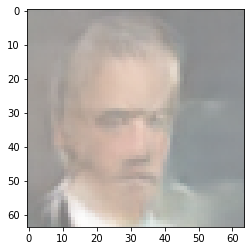

Batch: 550 Generator Loss: 2.1311962962150575 Discriminator Loss: 0.417725573182106
Batch: 600 Generator Loss: 2.0912807357311247 Discriminator Loss: 0.437168547809124
Batch: 650 Generator Loss: 2.1433585119247436 Discriminator Loss: 0.35491462469100954
Batch: 700 Generator Loss: 2.2229795360565188 Discriminator Loss: 0.3748528853058815
Batch: 750 Generator Loss: 2.0978392362594604 Discriminator Loss: 0.36458287060260774
Batch: 800 Generator Loss: 2.1716971683502195 Discriminator Loss: 0.364139062166214
Batch: 850 Generator Loss: 2.163985106945038 Discriminator Loss: 0.3794104278087616
Batch: 900 Generator Loss: 2.2306544399261474 Discriminator Loss: 0.4023727414011955
Batch: 950 Generator Loss: 2.22007737159729 Discriminator Loss: 0.40371719241142273
Batch: 1000 Generator Loss: 2.084560265541077 Discriminator Loss: 0.401686949133873


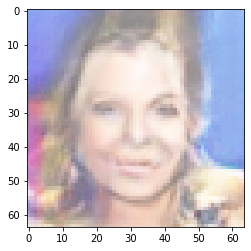

Batch: 1050 Generator Loss: 2.1333430671691893 Discriminator Loss: 0.38047253668308256
Batch: 1100 Generator Loss: 2.2124086809158325 Discriminator Loss: 0.4033565533161163
Batch: 1150 Generator Loss: 2.051626145839691 Discriminator Loss: 0.37995884478092196
Batch: 1200 Generator Loss: 2.1541349840164186 Discriminator Loss: 0.40439727663993835
Batch: 1250 Generator Loss: 2.249975707530975 Discriminator Loss: 0.43963968873023984
Batch: 1300 Generator Loss: 2.12707950592041 Discriminator Loss: 0.36467227935791013
Batch: 1350 Generator Loss: 2.1378476881980895 Discriminator Loss: 0.38348909199237824
Batch: 1400 Generator Loss: 2.1471187925338744 Discriminator Loss: 0.36655116617679595
Batch: 1450 Generator Loss: 2.185001266002655 Discriminator Loss: 0.3665983736515045
Batch: 1500 Generator Loss: 2.1992217826843263 Discriminator Loss: 0.38224216908216474


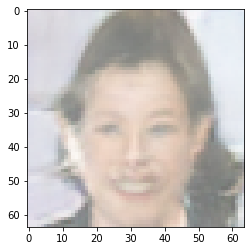

Batch: 1550 Generator Loss: 2.1578315758705138 Discriminator Loss: 0.3549153882265091


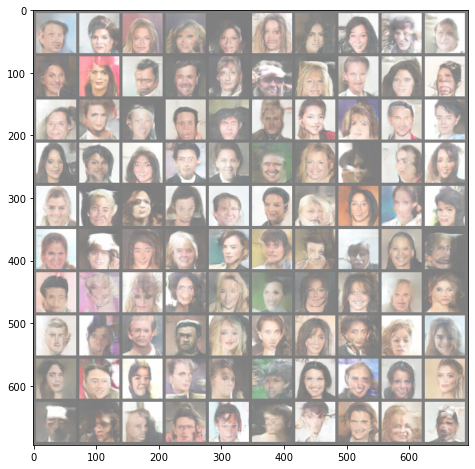

Epoch [1 / 15] average loss generator vs. discrim.: 3423.421304 vs. 613.264494

Batch: 50 Generator Loss: 2.25022846698761 Discriminator Loss: 0.37202591836452487
Batch: 100 Generator Loss: 2.163424253463745 Discriminator Loss: 0.38501865208148955
Batch: 150 Generator Loss: 2.178755965232849 Discriminator Loss: 0.37641831904649736
Batch: 200 Generator Loss: 2.1243271040916443 Discriminator Loss: 0.4140673500299454
Batch: 250 Generator Loss: 2.253658883571625 Discriminator Loss: 0.37614170283079146
Batch: 300 Generator Loss: 2.2185485422611237 Discriminator Loss: 0.42359961599111556
Batch: 350 Generator Loss: 2.1326953625679015 Discriminator Loss: 0.4089270907640457
Batch: 400 Generator Loss: 2.1503225803375243 Discriminator Loss: 0.3689682042598724
Batch: 450 Generator Loss: 2.1147727251052855 Discriminator Loss: 0.38312709987163546
Batch: 500 Generator Loss: 2.1504051804542543 Discriminator Loss: 0.3785493004322052


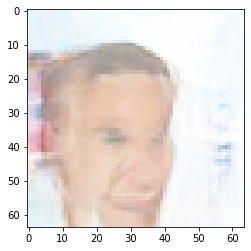

Batch: 550 Generator Loss: 2.1681596875190734 Discriminator Loss: 0.3854122322797775
Batch: 600 Generator Loss: 2.2248129081726074 Discriminator Loss: 0.37453398525714876
Batch: 650 Generator Loss: 2.177013568878174 Discriminator Loss: 0.36808492600917814
Batch: 700 Generator Loss: 2.2024576020240785 Discriminator Loss: 0.3588465481996536
Batch: 750 Generator Loss: 2.270729786157608 Discriminator Loss: 0.38644183993339537
Batch: 800 Generator Loss: 2.130646984577179 Discriminator Loss: 0.3821449089050293
Batch: 850 Generator Loss: 2.2251447427272795 Discriminator Loss: 0.40581191807985306
Batch: 900 Generator Loss: 2.1480896520614623 Discriminator Loss: 0.3597497582435608
Batch: 950 Generator Loss: 2.123199853897095 Discriminator Loss: 0.39354088783264163
Batch: 1000 Generator Loss: 2.2512759709358217 Discriminator Loss: 0.3799797821044922


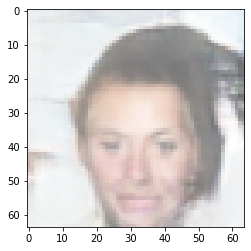

Batch: 1050 Generator Loss: 2.1816284465789795 Discriminator Loss: 0.3864692676067352
Batch: 1100 Generator Loss: 2.1865863013267517 Discriminator Loss: 0.35017345041036607
Batch: 1150 Generator Loss: 2.2739184415340423 Discriminator Loss: 0.4517473128437996
Batch: 1200 Generator Loss: 2.1542309653759 Discriminator Loss: 0.3935341638326645
Batch: 1250 Generator Loss: 2.237411253452301 Discriminator Loss: 0.3703710266947746
Batch: 1300 Generator Loss: 2.1434975147247313 Discriminator Loss: 0.3692085781693459
Batch: 1350 Generator Loss: 2.1600906467437744 Discriminator Loss: 0.36318515181541444
Batch: 1400 Generator Loss: 2.1992742252349853 Discriminator Loss: 0.3941682279109955
Batch: 1450 Generator Loss: 2.1591302227973936 Discriminator Loss: 0.37030727982521056
Batch: 1500 Generator Loss: 2.2026653134822847 Discriminator Loss: 0.3828317618370056


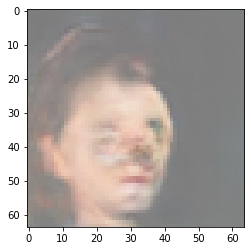

Batch: 1550 Generator Loss: 2.2341421067714693 Discriminator Loss: 0.38145673215389253


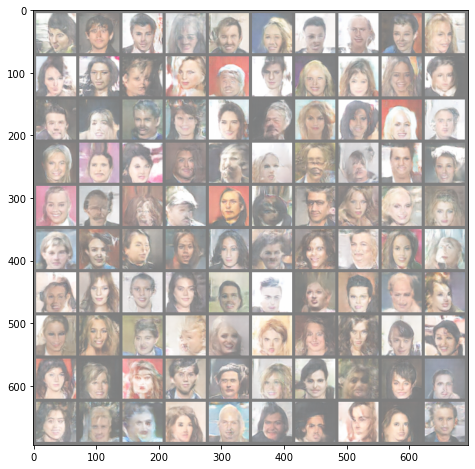

Epoch [2 / 15] average loss generator vs. discrim.: 3458.812017 vs. 607.934951

Batch: 50 Generator Loss: 2.134958324432373 Discriminator Loss: 0.3842394232749939
Batch: 100 Generator Loss: 2.1279735279083254 Discriminator Loss: 0.3635120743513107
Batch: 150 Generator Loss: 2.247006683349609 Discriminator Loss: 0.3404089069366455
Batch: 200 Generator Loss: 2.242834310531616 Discriminator Loss: 0.5000091576576233
Batch: 250 Generator Loss: 2.1734219431877135 Discriminator Loss: 0.38719698011875153
Batch: 300 Generator Loss: 2.151896562576294 Discriminator Loss: 0.37165107727050783
Batch: 350 Generator Loss: 2.1448187386989592 Discriminator Loss: 0.3500854182243347
Batch: 400 Generator Loss: 2.1012390494346618 Discriminator Loss: 0.3837490564584732
Batch: 450 Generator Loss: 2.123727127313614 Discriminator Loss: 0.3935359400510788
Batch: 500 Generator Loss: 2.0831902408599854 Discriminator Loss: 0.3675654196739197


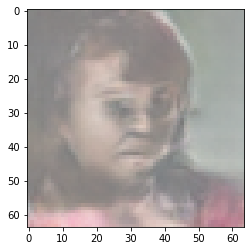

Batch: 550 Generator Loss: 2.3187336587905882 Discriminator Loss: 0.3749197965860367
Batch: 600 Generator Loss: 2.1326061451435088 Discriminator Loss: 0.3819479733705521
Batch: 650 Generator Loss: 2.1603805470466613 Discriminator Loss: 0.3830653429031372
Batch: 700 Generator Loss: 2.18308757185936 Discriminator Loss: 0.3698535692691803
Batch: 750 Generator Loss: 2.208901104927063 Discriminator Loss: 0.3554358410835266
Batch: 800 Generator Loss: 2.1951989114284514 Discriminator Loss: 0.45656724512577057
Batch: 850 Generator Loss: 2.184045112133026 Discriminator Loss: 0.4216259843111038
Batch: 900 Generator Loss: 2.200315012931824 Discriminator Loss: 0.41278638631105424
Batch: 950 Generator Loss: 2.192200744152069 Discriminator Loss: 0.379884170293808
Batch: 1000 Generator Loss: 2.129618649482727 Discriminator Loss: 0.36608499109745024


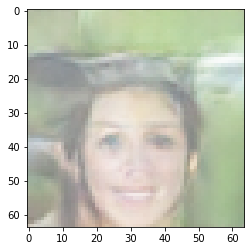

Batch: 1050 Generator Loss: 2.2279375314712526 Discriminator Loss: 0.3648819145560265
Batch: 1100 Generator Loss: 2.1590381026268006 Discriminator Loss: 0.36663385629653933
Batch: 1150 Generator Loss: 2.281977717876434 Discriminator Loss: 0.34693162620067597
Batch: 1200 Generator Loss: 2.2053339505195617 Discriminator Loss: 0.3560619789361954
Batch: 1250 Generator Loss: 2.1111467802524566 Discriminator Loss: 0.38003890454769135
Batch: 1300 Generator Loss: 2.1035401725769045 Discriminator Loss: 0.3704868993163109
Batch: 1350 Generator Loss: 2.222961599826813 Discriminator Loss: 0.35546772837638857
Batch: 1400 Generator Loss: 2.2266033685207365 Discriminator Loss: 0.37741579353809357
Batch: 1450 Generator Loss: 2.2356010770797727 Discriminator Loss: 0.35997264862060546
Batch: 1500 Generator Loss: 2.284398925304413 Discriminator Loss: 0.36317102670669554


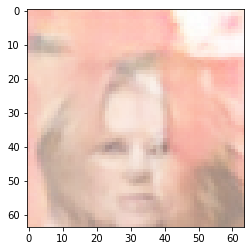

Batch: 1550 Generator Loss: 2.1716847705841062 Discriminator Loss: 0.3897490137815475


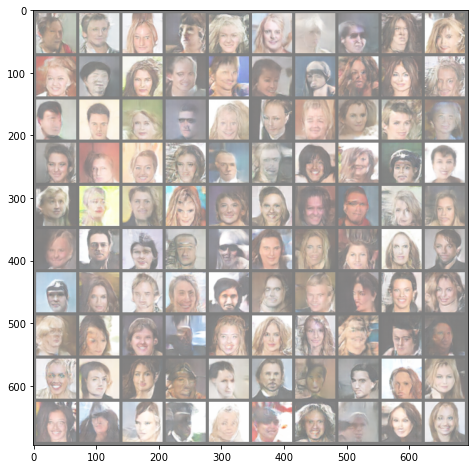

Epoch [3 / 15] average loss generator vs. discrim.: 3455.837332 vs. 600.573077

Batch: 50 Generator Loss: 2.192729480266571 Discriminator Loss: 0.39036541104316713
Batch: 100 Generator Loss: 2.1463029909133913 Discriminator Loss: 0.3811123114824295
Batch: 150 Generator Loss: 2.1370684909820556 Discriminator Loss: 0.3769596111774445
Batch: 200 Generator Loss: 2.2647989642620088 Discriminator Loss: 0.40557398080825807
Batch: 250 Generator Loss: 2.217746629714966 Discriminator Loss: 0.38292083263397214
Batch: 300 Generator Loss: 2.1622080099582672 Discriminator Loss: 0.3978813326358795
Batch: 350 Generator Loss: 2.159976364374161 Discriminator Loss: 0.3711590111255646
Batch: 400 Generator Loss: 2.2153586411476134 Discriminator Loss: 0.3653646436333656
Batch: 450 Generator Loss: 2.215824671983719 Discriminator Loss: 0.38908614933490754
Batch: 500 Generator Loss: 2.195409095287323 Discriminator Loss: 0.35539855420589445


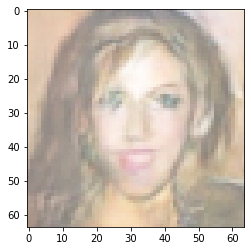

Batch: 550 Generator Loss: 2.1757189428806303 Discriminator Loss: 0.37129578351974485
Batch: 600 Generator Loss: 2.1874280428886412 Discriminator Loss: 0.3741126090288162
Batch: 650 Generator Loss: 2.230946478843689 Discriminator Loss: 0.36616892158985137
Batch: 700 Generator Loss: 2.191489245891571 Discriminator Loss: 0.41138903081417083
Batch: 750 Generator Loss: 2.1781883239746094 Discriminator Loss: 0.3773461502790451
Batch: 800 Generator Loss: 2.1162017798423767 Discriminator Loss: 0.3692646536231041
Batch: 850 Generator Loss: 2.2119099462032317 Discriminator Loss: 0.3794106405973434
Batch: 900 Generator Loss: 2.268102142214775 Discriminator Loss: 0.4329510921239853
Batch: 950 Generator Loss: 2.066311726570129 Discriminator Loss: 0.46782167434692384
Batch: 1000 Generator Loss: 2.1531095767021178 Discriminator Loss: 0.35885169625282287


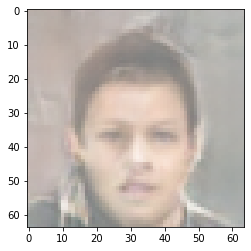

Batch: 1050 Generator Loss: 2.13169531583786 Discriminator Loss: 0.3745289373397827
Batch: 1100 Generator Loss: 2.207734807729721 Discriminator Loss: 0.35479285061359406
Batch: 1150 Generator Loss: 2.19053334236145 Discriminator Loss: 0.3646247237920761
Batch: 1200 Generator Loss: 2.198913733959198 Discriminator Loss: 0.35327077001333235
Batch: 1250 Generator Loss: 2.26220129609108 Discriminator Loss: 0.37319510817527773
Batch: 1300 Generator Loss: 2.175044527053833 Discriminator Loss: 0.3659705638885498
Batch: 1350 Generator Loss: 2.1921016144752503 Discriminator Loss: 0.40036279141902925
Batch: 1400 Generator Loss: 2.2046396958827974 Discriminator Loss: 0.3821185851097107
Batch: 1450 Generator Loss: 2.133269181251526 Discriminator Loss: 0.3720418775081635
Batch: 1500 Generator Loss: 2.185809440612793 Discriminator Loss: 0.3622990956902504


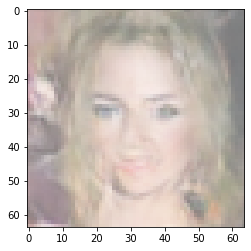

Batch: 1550 Generator Loss: 2.220616652965546 Discriminator Loss: 0.38550501465797427


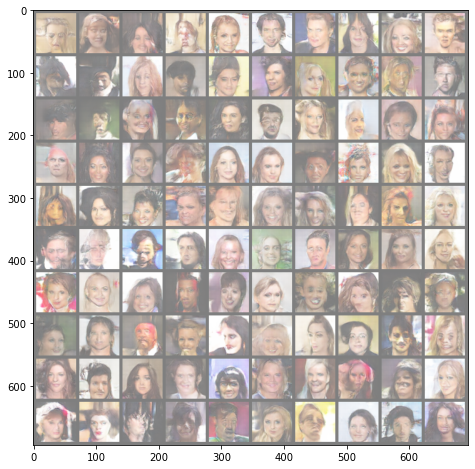

Epoch [4 / 15] average loss generator vs. discrim.: 3463.613797 vs. 602.545469

Batch: 50 Generator Loss: 2.2500167083740235 Discriminator Loss: 0.36789353281259535
Batch: 100 Generator Loss: 2.1829568672180177 Discriminator Loss: 0.37501618146896365
Batch: 150 Generator Loss: 2.1977307391166687 Discriminator Loss: 0.38716485679149626
Batch: 200 Generator Loss: 2.208199996948242 Discriminator Loss: 0.3575175130367279
Batch: 250 Generator Loss: 2.1990739941596984 Discriminator Loss: 0.35464627265930176
Batch: 300 Generator Loss: 2.2201493644714354 Discriminator Loss: 0.4572801059484482
Batch: 350 Generator Loss: 2.1765167188644408 Discriminator Loss: 0.4120988994836807
Batch: 400 Generator Loss: 2.171581698656082 Discriminator Loss: 0.37051026582717894
Batch: 450 Generator Loss: 2.1451355910301206 Discriminator Loss: 0.40099895298480986
Batch: 500 Generator Loss: 2.160564057826996 Discriminator Loss: 0.37703721165657045


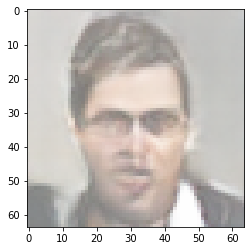

Batch: 550 Generator Loss: 2.1743275785446166 Discriminator Loss: 0.36384308964014056
Batch: 600 Generator Loss: 2.101972289085388 Discriminator Loss: 0.36844435453414914
Batch: 650 Generator Loss: 2.156043848991394 Discriminator Loss: 0.3693179443478584
Batch: 700 Generator Loss: 2.220389144420624 Discriminator Loss: 0.36897704243659973
Batch: 750 Generator Loss: 2.1880562222003936 Discriminator Loss: 0.40178114861249925
Batch: 800 Generator Loss: 2.110039942264557 Discriminator Loss: 0.3815757006406784
Batch: 850 Generator Loss: 2.1347540426254272 Discriminator Loss: 0.388585647046566
Batch: 900 Generator Loss: 2.1841012382507325 Discriminator Loss: 0.3621560961008072
Batch: 950 Generator Loss: 2.190189037322998 Discriminator Loss: 0.37057028591632846
Batch: 1000 Generator Loss: 2.248924516439438 Discriminator Loss: 0.3880083078145981


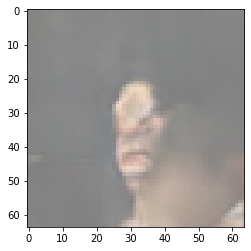

Batch: 1050 Generator Loss: 2.188003041744232 Discriminator Loss: 0.3741746085882187
Batch: 1100 Generator Loss: 2.2505173540115355 Discriminator Loss: 0.36677609622478485
Batch: 1150 Generator Loss: 2.306878222823143 Discriminator Loss: 0.4557338082790375
Batch: 1200 Generator Loss: 2.1136148726940154 Discriminator Loss: 0.43148953139781954
Batch: 1250 Generator Loss: 2.0922730207443236 Discriminator Loss: 0.36722259104251864
Batch: 1300 Generator Loss: 2.09673392534256 Discriminator Loss: 0.38380649030208586
Batch: 1350 Generator Loss: 2.1354753828048705 Discriminator Loss: 0.3661172264814377
Batch: 1400 Generator Loss: 2.120882647037506 Discriminator Loss: 0.369778853058815
Batch: 1450 Generator Loss: 2.1687412536144257 Discriminator Loss: 0.37423052489757536
Batch: 1500 Generator Loss: 2.10213552236557 Discriminator Loss: 0.3823701575398445


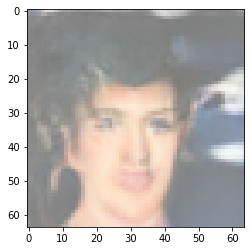

Batch: 1550 Generator Loss: 2.1002289879322054 Discriminator Loss: 0.381145344376564


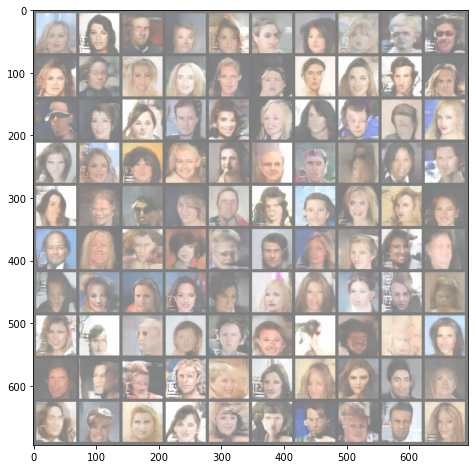

Epoch [5 / 15] average loss generator vs. discrim.: 3434.833268 vs. 606.515363

Batch: 50 Generator Loss: 2.210858290195465 Discriminator Loss: 0.36842590391635893
Batch: 100 Generator Loss: 2.2451971232891084 Discriminator Loss: 0.37765899240970613
Batch: 150 Generator Loss: 2.1553344249725344 Discriminator Loss: 0.39014393121004104
Batch: 200 Generator Loss: 2.2238750863075256 Discriminator Loss: 0.3516401496529579
Batch: 250 Generator Loss: 2.2159434866905214 Discriminator Loss: 0.38589998036623
Batch: 300 Generator Loss: 2.2743934881687164 Discriminator Loss: 0.3651520186662674
Batch: 350 Generator Loss: 2.2206454372406004 Discriminator Loss: 0.38076345443725584
Batch: 400 Generator Loss: 2.1736844611167907 Discriminator Loss: 0.3715434491634369
Batch: 450 Generator Loss: 2.2144238471984865 Discriminator Loss: 0.3665486514568329
Batch: 500 Generator Loss: 2.1921044850349425 Discriminator Loss: 0.3590991503000259


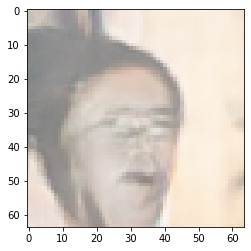

Batch: 550 Generator Loss: 2.228405084609985 Discriminator Loss: 0.3861173236370087
Batch: 600 Generator Loss: 2.2856966280937194 Discriminator Loss: 0.39952786803245544
Batch: 650 Generator Loss: 2.1941511821746826 Discriminator Loss: 0.36475082248449325
Batch: 700 Generator Loss: 2.2415041720867155 Discriminator Loss: 0.4008068245649338
Batch: 750 Generator Loss: 2.2150230050086974 Discriminator Loss: 0.39049474626779557
Batch: 800 Generator Loss: 2.157788619995117 Discriminator Loss: 0.37464379519224167
Batch: 850 Generator Loss: 2.1973546290397645 Discriminator Loss: 0.35555305987596514
Batch: 900 Generator Loss: 2.2249070692062376 Discriminator Loss: 0.3838673764467239
Batch: 950 Generator Loss: 2.1708585143089296 Discriminator Loss: 0.3525931790471077
Batch: 1000 Generator Loss: 2.239285614490509 Discriminator Loss: 0.3939807718992233


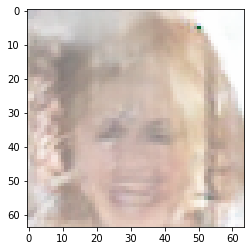

Batch: 1050 Generator Loss: 2.494449184536934 Discriminator Loss: 0.4500889173150063
Batch: 1100 Generator Loss: 2.1942510437965392 Discriminator Loss: 0.41622058510780335
Batch: 1150 Generator Loss: 2.0557424449920654 Discriminator Loss: 0.3824479442834854
Batch: 1200 Generator Loss: 2.069536168575287 Discriminator Loss: 0.4005548712611198
Batch: 1250 Generator Loss: 2.1940765452384947 Discriminator Loss: 0.3647878670692444
Batch: 1300 Generator Loss: 2.21097838640213 Discriminator Loss: 0.37286254107952116
Batch: 1350 Generator Loss: 2.17303750038147 Discriminator Loss: 0.3497677364945412
Batch: 1400 Generator Loss: 2.1633919215202333 Discriminator Loss: 0.3763790851831436
Batch: 1450 Generator Loss: 2.1734920179843904 Discriminator Loss: 0.5174695563316345
Batch: 1500 Generator Loss: 2.025658297538757 Discriminator Loss: 0.3952199679613113


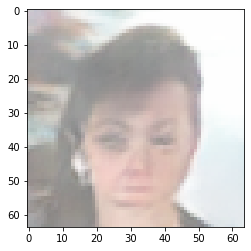

Batch: 1550 Generator Loss: 2.076526873111725 Discriminator Loss: 0.37160870015621184


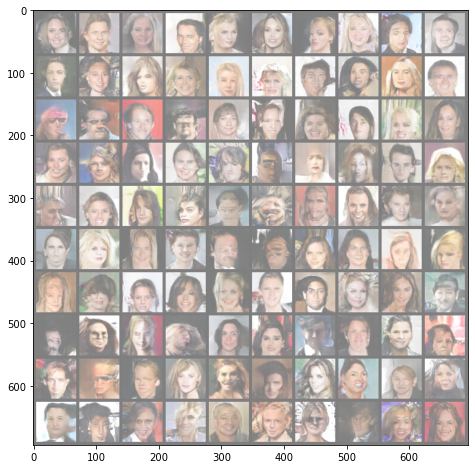

Epoch [6 / 15] average loss generator vs. discrim.: 3476.854252 vs. 607.687365

Batch: 50 Generator Loss: 2.122682774066925 Discriminator Loss: 0.37057038843631745
Batch: 100 Generator Loss: 2.126808807849884 Discriminator Loss: 0.381666100025177
Batch: 150 Generator Loss: 2.1094504261016844 Discriminator Loss: 0.3517174565792084
Batch: 200 Generator Loss: 2.1642741054296493 Discriminator Loss: 0.418111572265625
Batch: 250 Generator Loss: 2.13100878238678 Discriminator Loss: 0.36666337490081785
Batch: 300 Generator Loss: 2.193853144645691 Discriminator Loss: 0.394424786567688
Batch: 350 Generator Loss: 2.1511302375793457 Discriminator Loss: 0.36514549106359484
Batch: 400 Generator Loss: 2.249290356636047 Discriminator Loss: 0.36089182436466216
Batch: 450 Generator Loss: 2.1555779588222506 Discriminator Loss: 0.3784540942311287
Batch: 500 Generator Loss: 2.181558380126953 Discriminator Loss: 0.3572618794441223


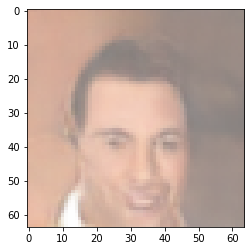

Batch: 550 Generator Loss: 2.194446873664856 Discriminator Loss: 0.34919966131448743
Batch: 600 Generator Loss: 2.14865074634552 Discriminator Loss: 0.36855503380298615
Batch: 650 Generator Loss: 2.2113535261154174 Discriminator Loss: 0.3749400287866592
Batch: 700 Generator Loss: 2.254348265528679 Discriminator Loss: 0.43904389441013336
Batch: 750 Generator Loss: 2.141887753009796 Discriminator Loss: 0.3757371217012405
Batch: 800 Generator Loss: 2.1751906085014343 Discriminator Loss: 0.3639103052020073
Batch: 850 Generator Loss: 2.223915784358978 Discriminator Loss: 0.3745435866713524
Batch: 900 Generator Loss: 2.238705747127533 Discriminator Loss: 0.35345092296600344
Batch: 950 Generator Loss: 2.133475799560547 Discriminator Loss: 0.35679271280765534
Batch: 1000 Generator Loss: 2.2709768486022948 Discriminator Loss: 0.33641828209161756


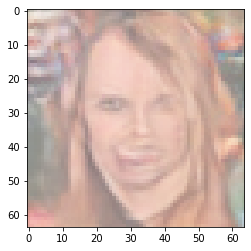

Batch: 1050 Generator Loss: 2.2000086641311647 Discriminator Loss: 0.40633205235004427
Batch: 1100 Generator Loss: 2.1759049248695375 Discriminator Loss: 0.3874667644500732
Batch: 1150 Generator Loss: 2.1963678216934204 Discriminator Loss: 0.35103943407535554
Batch: 1200 Generator Loss: 2.246244937181473 Discriminator Loss: 0.4456664651632309
Batch: 1250 Generator Loss: 2.122644809484482 Discriminator Loss: 0.4036440339684486
Batch: 1300 Generator Loss: 2.2088906025886534 Discriminator Loss: 0.3853220248222351
Batch: 1350 Generator Loss: 2.166838839054108 Discriminator Loss: 0.35907345563173293
Batch: 1400 Generator Loss: 2.2449275517463683 Discriminator Loss: 0.3744795203208923
Batch: 1450 Generator Loss: 2.146425428390503 Discriminator Loss: 0.3664776808023453
Batch: 1500 Generator Loss: 2.2357369089126586 Discriminator Loss: 0.35741440117359163


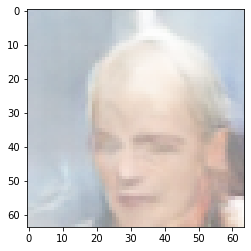

Batch: 1550 Generator Loss: 2.207447123527527 Discriminator Loss: 0.365364750623703


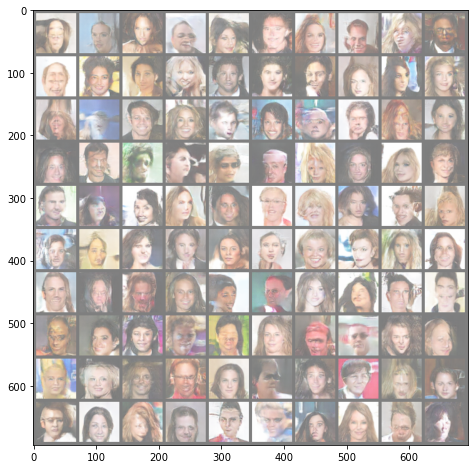

Epoch [7 / 15] average loss generator vs. discrim.: 3466.614808 vs. 594.461735

Batch: 50 Generator Loss: 2.206335300207138 Discriminator Loss: 0.3831018814444542
Batch: 100 Generator Loss: 2.206065989732742 Discriminator Loss: 0.37490682154893873
Batch: 150 Generator Loss: 2.1649215698242186 Discriminator Loss: 0.3596865051984787
Batch: 200 Generator Loss: 2.137976427078247 Discriminator Loss: 0.3674024599790573
Batch: 250 Generator Loss: 2.22385511636734 Discriminator Loss: 0.39131607711315153
Batch: 300 Generator Loss: 2.1626838564872743 Discriminator Loss: 0.36699890583753586
Batch: 350 Generator Loss: 2.219713169336319 Discriminator Loss: 0.3814279875159264
Batch: 400 Generator Loss: 2.205171811580658 Discriminator Loss: 0.40122878074645996
Batch: 450 Generator Loss: 2.1972886443138124 Discriminator Loss: 0.35789326518774034
Batch: 500 Generator Loss: 2.192139759063721 Discriminator Loss: 0.38285329163074494


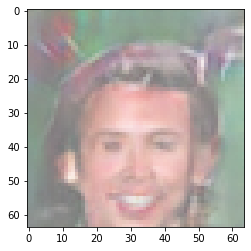

Batch: 550 Generator Loss: 2.2373796463012696 Discriminator Loss: 0.36248706698417665
Batch: 600 Generator Loss: 2.2292300152778624 Discriminator Loss: 0.3463490691781044
Batch: 650 Generator Loss: 2.1629810428619383 Discriminator Loss: 0.394564191699028
Batch: 700 Generator Loss: 2.1625202810764312 Discriminator Loss: 0.3829008650779724
Batch: 750 Generator Loss: 2.177805337905884 Discriminator Loss: 0.41136682152748105
Batch: 800 Generator Loss: 2.1746268010139467 Discriminator Loss: 0.3559782361984253
Batch: 850 Generator Loss: 2.2433490562438965 Discriminator Loss: 0.35872915863990784
Batch: 900 Generator Loss: 2.1804182720184326 Discriminator Loss: 0.36454237341880796
Batch: 950 Generator Loss: 2.2429715728759767 Discriminator Loss: 0.36166119426488874
Batch: 1000 Generator Loss: 2.219150273799896 Discriminator Loss: 0.370332758128643


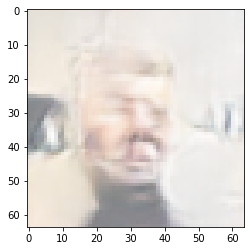

Batch: 1050 Generator Loss: 2.1694349598884584 Discriminator Loss: 0.368420894742012
Batch: 1100 Generator Loss: 2.23566326379776 Discriminator Loss: 0.35825849056243897
Batch: 1150 Generator Loss: 2.176007504463196 Discriminator Loss: 0.378864226937294
Batch: 1200 Generator Loss: 2.304831691980362 Discriminator Loss: 0.470285564661026
Batch: 1250 Generator Loss: 2.189100887775421 Discriminator Loss: 0.3451794570684433
Batch: 1300 Generator Loss: 2.25163818359375 Discriminator Loss: 0.3503568395972252
Batch: 1350 Generator Loss: 2.1715631854534148 Discriminator Loss: 0.3852294558286667
Batch: 1400 Generator Loss: 2.2200761365890505 Discriminator Loss: 0.34351765125989914
Batch: 1450 Generator Loss: 2.2009000825881957 Discriminator Loss: 0.377178328037262
Batch: 1500 Generator Loss: 2.205983738899231 Discriminator Loss: 0.36146087646484376


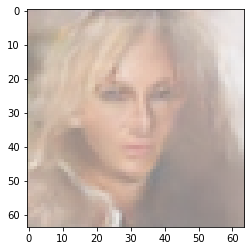

Batch: 1550 Generator Loss: 2.1538988876342775 Discriminator Loss: 0.3635369631648064


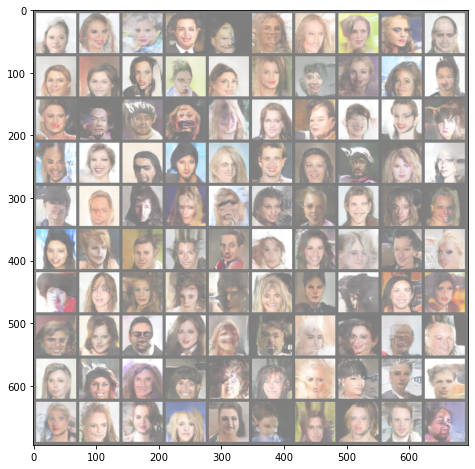

Epoch [8 / 15] average loss generator vs. discrim.: 3487.260954 vs. 591.557645

Batch: 50 Generator Loss: 2.1914557313919065 Discriminator Loss: 0.38468354403972627
Batch: 100 Generator Loss: 2.2274400985240934 Discriminator Loss: 0.4942953431606293
Batch: 150 Generator Loss: 2.200983784198761 Discriminator Loss: 0.3744032663106918
Batch: 200 Generator Loss: 2.209183075428009 Discriminator Loss: 0.36460102260112764
Batch: 250 Generator Loss: 2.215019016265869 Discriminator Loss: 0.3412516161799431
Batch: 300 Generator Loss: 2.195417351722717 Discriminator Loss: 0.36957864433526993
Batch: 350 Generator Loss: 2.187715971469879 Discriminator Loss: 0.3604220551252365
Batch: 400 Generator Loss: 2.213073105812073 Discriminator Loss: 0.3588928109407425
Batch: 450 Generator Loss: 2.1034992003440856 Discriminator Loss: 0.3706970262527466
Batch: 500 Generator Loss: 2.1867346143722535 Discriminator Loss: 0.3699450245499611


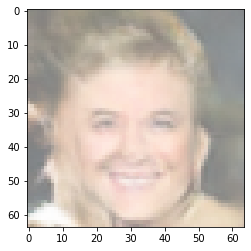

Batch: 550 Generator Loss: 2.234696083068848 Discriminator Loss: 0.34177468687295914
Batch: 600 Generator Loss: 2.220679371356964 Discriminator Loss: 0.38210823595523835
Batch: 650 Generator Loss: 2.2383637714385984 Discriminator Loss: 0.3594323590397835
Batch: 700 Generator Loss: 2.101837685108185 Discriminator Loss: 0.376707324385643
Batch: 750 Generator Loss: 2.1091249412298203 Discriminator Loss: 0.5694650101661682
Batch: 800 Generator Loss: 2.127861602306366 Discriminator Loss: 0.41003507018089297
Batch: 850 Generator Loss: 2.1015785050392153 Discriminator Loss: 0.3743902552127838
Batch: 900 Generator Loss: 2.1407521057128904 Discriminator Loss: 0.362965093255043
Batch: 950 Generator Loss: 2.1863463747501375 Discriminator Loss: 0.3895951932668686
Batch: 1000 Generator Loss: 2.1445555233955385 Discriminator Loss: 0.3603535506129265


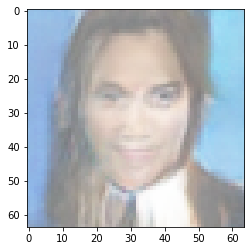

Batch: 1050 Generator Loss: 2.1347452652454377 Discriminator Loss: 0.37162970066070555
Batch: 1100 Generator Loss: 2.1521093153953554 Discriminator Loss: 0.35311579793691633
Batch: 1150 Generator Loss: 2.182593722343445 Discriminator Loss: 0.37003030121326447
Batch: 1200 Generator Loss: 2.186416058540344 Discriminator Loss: 0.35598560243844984
Batch: 1250 Generator Loss: 2.2657944464683535 Discriminator Loss: 0.3691860231757164
Batch: 1300 Generator Loss: 2.214278452396393 Discriminator Loss: 0.37519300013780593
Batch: 1350 Generator Loss: 2.150028371810913 Discriminator Loss: 0.3628858122229576
Batch: 1400 Generator Loss: 2.2085590744018555 Discriminator Loss: 0.3775941640138626
Batch: 1450 Generator Loss: 2.1326969337463377 Discriminator Loss: 0.3840159720182419
Batch: 1500 Generator Loss: 2.1440996623039243 Discriminator Loss: 0.37401996076107025


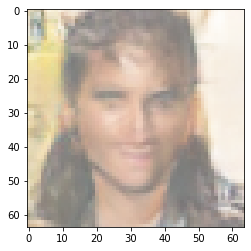

Batch: 1550 Generator Loss: 2.2265500903129576 Discriminator Loss: 0.3507640999555588


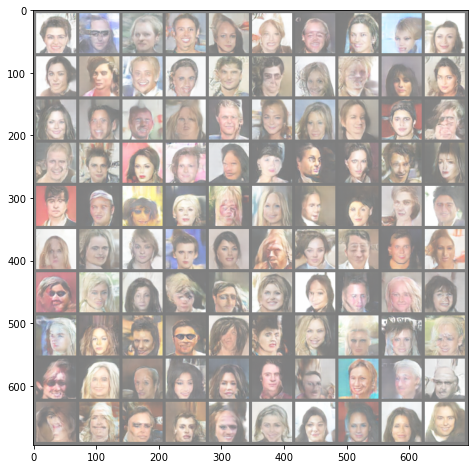

Epoch [9 / 15] average loss generator vs. discrim.: 3451.180864 vs. 600.234854

Batch: 50 Generator Loss: 2.2392289638519287 Discriminator Loss: 0.37293036103248595
Batch: 100 Generator Loss: 2.1913549268245696 Discriminator Loss: 0.4885881906747818
Batch: 150 Generator Loss: 2.148820261955261 Discriminator Loss: 0.3795767205953598
Batch: 200 Generator Loss: 2.1531942009925844 Discriminator Loss: 0.3894534969329834
Batch: 250 Generator Loss: 2.175224552154541 Discriminator Loss: 0.3735364353656769
Batch: 300 Generator Loss: 2.1903703236579894 Discriminator Loss: 0.3538014853000641
Batch: 350 Generator Loss: 2.2196895051002503 Discriminator Loss: 0.36775256812572477
Batch: 400 Generator Loss: 2.19984232544899 Discriminator Loss: 0.376759879887104
Batch: 450 Generator Loss: 2.1240236592292785 Discriminator Loss: 0.36856725573539734
Batch: 500 Generator Loss: 2.267186051607132 Discriminator Loss: 0.3637387675046921


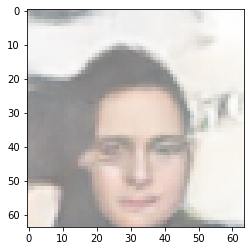

Batch: 550 Generator Loss: 2.204720264673233 Discriminator Loss: 0.3753979706764221
Batch: 600 Generator Loss: 2.1873762226104736 Discriminator Loss: 0.36613294303417204
Batch: 650 Generator Loss: 2.1734008836746215 Discriminator Loss: 0.38361949861049655
Batch: 700 Generator Loss: 2.1847867465019224 Discriminator Loss: 0.37821006298065185
Batch: 750 Generator Loss: 2.2139109420776366 Discriminator Loss: 0.3723659405112267
Batch: 800 Generator Loss: 2.154452393054962 Discriminator Loss: 0.35975379109382627
Batch: 850 Generator Loss: 2.2052090728282927 Discriminator Loss: 0.458722737133503
Batch: 900 Generator Loss: 2.1787850952148435 Discriminator Loss: 0.3717879456281662
Batch: 950 Generator Loss: 2.184625222682953 Discriminator Loss: 0.3522502800822258
Batch: 1000 Generator Loss: 2.2854864954948426 Discriminator Loss: 0.3700418242812157


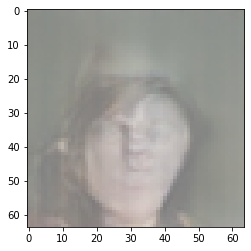

Batch: 1050 Generator Loss: 2.2451294088363647 Discriminator Loss: 0.3506742280721664
Batch: 1100 Generator Loss: 2.148228898048401 Discriminator Loss: 0.36489004254341123
Batch: 1150 Generator Loss: 2.1908405661582946 Discriminator Loss: 0.35866642981767655
Batch: 1200 Generator Loss: 2.2048192751407623 Discriminator Loss: 0.43568306148052216
Batch: 1250 Generator Loss: 2.1726002168655394 Discriminator Loss: 0.3945097106695175
Batch: 1300 Generator Loss: 2.195292043685913 Discriminator Loss: 0.3790789347887039
Batch: 1350 Generator Loss: 2.1929059553146364 Discriminator Loss: 0.3427680605649948
Batch: 1400 Generator Loss: 2.262474629878998 Discriminator Loss: 0.361103652715683
Batch: 1450 Generator Loss: 2.220240983963013 Discriminator Loss: 0.3729477816820145
Batch: 1500 Generator Loss: 2.1356030321121215 Discriminator Loss: 0.36277045398950575


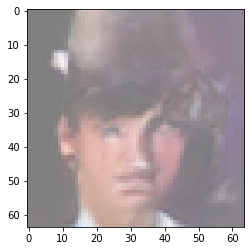

Batch: 1550 Generator Loss: 2.203990943431854 Discriminator Loss: 0.36103028982877733


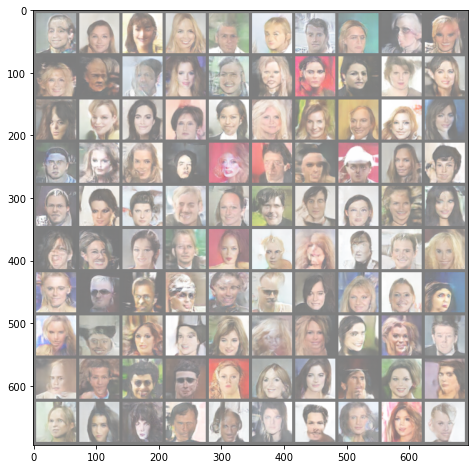

Epoch [10 / 15] average loss generator vs. discrim.: 3476.626390 vs. 597.092133

Batch: 50 Generator Loss: 2.2189590430259702 Discriminator Loss: 0.3551887309551239
Batch: 100 Generator Loss: 2.1350533890724184 Discriminator Loss: 0.3681049972772598
Batch: 150 Generator Loss: 2.1855664157867434 Discriminator Loss: 0.38985022127628327
Batch: 200 Generator Loss: 2.1506180143356324 Discriminator Loss: 0.37606945365667344
Batch: 250 Generator Loss: 2.253114753961563 Discriminator Loss: 0.4956179118156433
Batch: 300 Generator Loss: 2.1846831917762755 Discriminator Loss: 0.35154229938983916
Batch: 350 Generator Loss: 2.1464331698417665 Discriminator Loss: 0.38067892134189607
Batch: 400 Generator Loss: 2.1543409037590027 Discriminator Loss: 0.37030229210853577
Batch: 450 Generator Loss: 2.18213805437088 Discriminator Loss: 0.36136915743350984
Batch: 500 Generator Loss: 2.191650333404541 Discriminator Loss: 0.3479331624507904


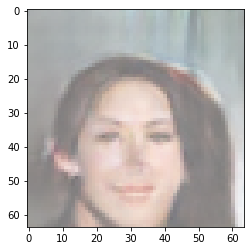

Batch: 550 Generator Loss: 2.1550848484039307 Discriminator Loss: 0.38288881540298464
Batch: 600 Generator Loss: 2.1256817293167116 Discriminator Loss: 0.3758632868528366
Batch: 650 Generator Loss: 2.2629214262962343 Discriminator Loss: 0.35596825540065763
Batch: 700 Generator Loss: 2.2351957499980926 Discriminator Loss: 0.35481171011924745
Batch: 750 Generator Loss: 2.2067583441734313 Discriminator Loss: 0.3691888231039047
Batch: 800 Generator Loss: 2.2844877195358277 Discriminator Loss: 0.3838429266214371
Batch: 850 Generator Loss: 2.264551122188568 Discriminator Loss: 0.34140624701976774
Batch: 900 Generator Loss: 2.2433432179689405 Discriminator Loss: 0.4574880349636078
Batch: 950 Generator Loss: 2.2312706017494204 Discriminator Loss: 0.38483362674713134
Batch: 1000 Generator Loss: 2.22810067653656 Discriminator Loss: 0.3554707923531532


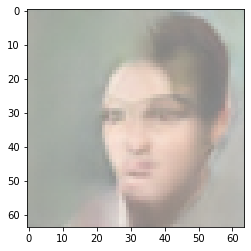

Batch: 1050 Generator Loss: 2.2166054582595827 Discriminator Loss: 0.36499460399150846
Batch: 1100 Generator Loss: 2.2124643230438235 Discriminator Loss: 0.34727524757385253
Batch: 1150 Generator Loss: 2.2576612496376036 Discriminator Loss: 0.38118385314941405
Batch: 1200 Generator Loss: 2.163908132314682 Discriminator Loss: 0.3744148761034012
Batch: 1250 Generator Loss: 2.1726108622550964 Discriminator Loss: 0.35794232189655306
Batch: 1300 Generator Loss: 2.269446815252304 Discriminator Loss: 0.35768937289714814
Batch: 1350 Generator Loss: 2.2265886187553408 Discriminator Loss: 0.3800672781467438
Batch: 1400 Generator Loss: 2.1958782124519347 Discriminator Loss: 0.36275132894515993
Batch: 1450 Generator Loss: 2.2401605582237245 Discriminator Loss: 0.3677407318353653
Batch: 1500 Generator Loss: 2.2934858191013334 Discriminator Loss: 0.3825277641415596


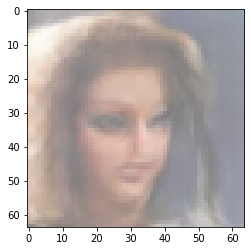

Batch: 1550 Generator Loss: 2.1611475598812104 Discriminator Loss: 0.37606690645217894


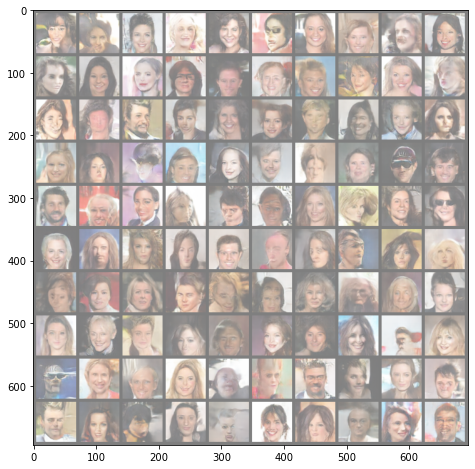

Epoch [11 / 15] average loss generator vs. discrim.: 3496.469959 vs. 592.261113

Batch: 50 Generator Loss: 2.1975720524787903 Discriminator Loss: 0.3992474490404129
Batch: 100 Generator Loss: 2.163786907196045 Discriminator Loss: 0.354120015501976
Batch: 150 Generator Loss: 2.182438516616821 Discriminator Loss: 0.3568245521187782
Batch: 200 Generator Loss: 2.1654006958007814 Discriminator Loss: 0.3654971647262573
Batch: 250 Generator Loss: 2.132497708797455 Discriminator Loss: 0.37166697561740875
Batch: 300 Generator Loss: 2.2656908214092253 Discriminator Loss: 0.37066621601581573
Batch: 350 Generator Loss: 2.235606117248535 Discriminator Loss: 0.36573547691106795
Batch: 400 Generator Loss: 2.2157902979850768 Discriminator Loss: 0.36945872962474824
Batch: 450 Generator Loss: 2.1846299076080324 Discriminator Loss: 0.3777583479881287
Batch: 500 Generator Loss: 2.2894481194019316 Discriminator Loss: 0.37028571605682375


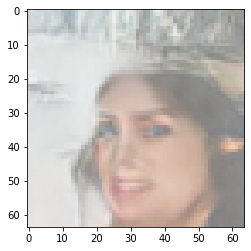

Batch: 550 Generator Loss: 2.1357701349258424 Discriminator Loss: 0.3664131331443787
Batch: 600 Generator Loss: 2.3011189675331116 Discriminator Loss: 0.5414259472489357
Batch: 650 Generator Loss: 2.1177853715419768 Discriminator Loss: 0.40921790719032286
Batch: 700 Generator Loss: 2.0555401158332827 Discriminator Loss: 0.37060595929622653
Batch: 750 Generator Loss: 2.111500453948975 Discriminator Loss: 0.3695011579990387
Batch: 800 Generator Loss: 2.0973474168777466 Discriminator Loss: 0.36417876422405243
Batch: 850 Generator Loss: 2.0922574949264527 Discriminator Loss: 0.3737075525522232
Batch: 900 Generator Loss: 2.1612240755558014 Discriminator Loss: 0.36070561230182646
Batch: 950 Generator Loss: 2.2745818746089936 Discriminator Loss: 0.38580357015132904
Batch: 1000 Generator Loss: 2.1721536338329317 Discriminator Loss: 0.3820213490724564


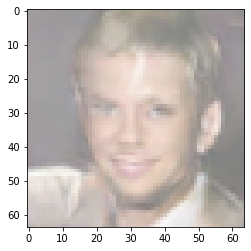

Batch: 1050 Generator Loss: 2.1441290307044985 Discriminator Loss: 0.3540975460410118
Batch: 1100 Generator Loss: 2.1964828419685363 Discriminator Loss: 0.3481186684966087
Batch: 1150 Generator Loss: 2.2342683768272398 Discriminator Loss: 0.39114064574241636
Batch: 1200 Generator Loss: 2.2125458025932314 Discriminator Loss: 0.3594567412137985
Batch: 1250 Generator Loss: 2.2984616923332215 Discriminator Loss: 0.3571955668926239
Batch: 1300 Generator Loss: 2.1963814187049864 Discriminator Loss: 0.3670572715997696
Batch: 1350 Generator Loss: 2.254589192867279 Discriminator Loss: 0.3521510910987854
Batch: 1400 Generator Loss: 2.117487179040909 Discriminator Loss: 0.3817213946580887
Batch: 1450 Generator Loss: 2.1661629700660705 Discriminator Loss: 0.36921296536922454
Batch: 1500 Generator Loss: 2.1632918417453766 Discriminator Loss: 0.40432349443435667


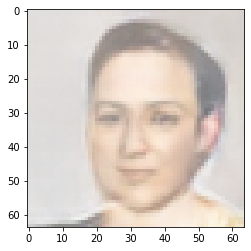

Batch: 1550 Generator Loss: 2.156153817176819 Discriminator Loss: 0.3618681621551514


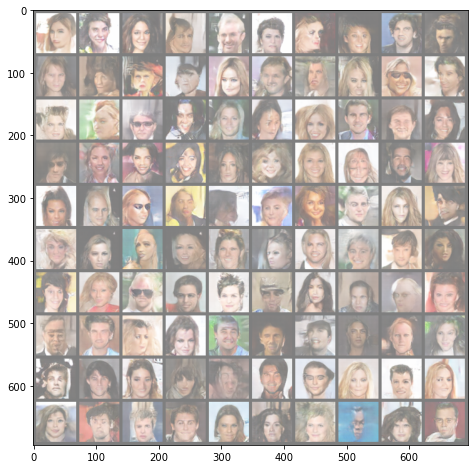

Epoch [12 / 15] average loss generator vs. discrim.: 3455.420264 vs. 595.671782

Batch: 50 Generator Loss: 2.192287223339081 Discriminator Loss: 0.3616060495376587
Batch: 100 Generator Loss: 2.1052286553382875 Discriminator Loss: 0.3747434240579605
Batch: 150 Generator Loss: 2.2249904692173006 Discriminator Loss: 0.40920930802822114
Batch: 200 Generator Loss: 2.1542816138267518 Discriminator Loss: 0.38428005993366243
Batch: 250 Generator Loss: 2.248973731994629 Discriminator Loss: 0.3506736406683922
Batch: 300 Generator Loss: 2.2082272332906725 Discriminator Loss: 0.5053436475992202
Batch: 350 Generator Loss: 2.1949685943126678 Discriminator Loss: 0.3823353624343872
Batch: 400 Generator Loss: 2.1301689195632934 Discriminator Loss: 0.3738949531316757
Batch: 450 Generator Loss: 2.1067603278160094 Discriminator Loss: 0.3671863633394241
Batch: 500 Generator Loss: 2.1564311158657072 Discriminator Loss: 0.3663110065460205


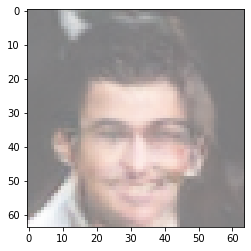

Batch: 550 Generator Loss: 2.226593668460846 Discriminator Loss: 0.3526371347904205
Batch: 600 Generator Loss: 2.209710024595261 Discriminator Loss: 0.36020318150520325
Batch: 650 Generator Loss: 2.220288324356079 Discriminator Loss: 0.36619880706071856
Batch: 700 Generator Loss: 2.246308331489563 Discriminator Loss: 0.3617590841650963
Batch: 750 Generator Loss: 2.1193016600608825 Discriminator Loss: 0.35425365388393404
Batch: 800 Generator Loss: 2.2445836186409 Discriminator Loss: 0.37074107706546783
Batch: 850 Generator Loss: 2.1919350701570512 Discriminator Loss: 0.41865555703639984
Batch: 900 Generator Loss: 2.196007881164551 Discriminator Loss: 0.35039637923240663
Batch: 950 Generator Loss: 2.1902800965309144 Discriminator Loss: 0.3718488624691963
Batch: 1000 Generator Loss: 2.2001016426086424 Discriminator Loss: 0.3593720042705536


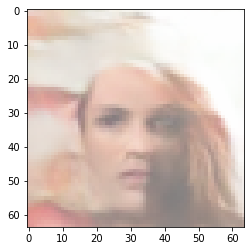

Batch: 1050 Generator Loss: 2.2372887420654295 Discriminator Loss: 0.35839735686779023
Batch: 1100 Generator Loss: 2.1815606224536896 Discriminator Loss: 0.3828404915332794
Batch: 1150 Generator Loss: 2.1497776246070863 Discriminator Loss: 0.36348919868469237
Batch: 1200 Generator Loss: 2.211421172618866 Discriminator Loss: 0.3587098452448845
Batch: 1250 Generator Loss: 2.2424684977531433 Discriminator Loss: 0.37037079215049745
Batch: 1300 Generator Loss: 2.2632111465930937 Discriminator Loss: 0.3870805475115776
Batch: 1350 Generator Loss: 2.149010797739029 Discriminator Loss: 0.37308907181024553
Batch: 1400 Generator Loss: 2.1742676603794098 Discriminator Loss: 0.38101303279399873
Batch: 1450 Generator Loss: 2.239746618270874 Discriminator Loss: 0.3490633460879326
Batch: 1500 Generator Loss: 2.193345584869385 Discriminator Loss: 0.3664814352989197


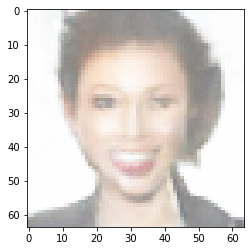

Batch: 1550 Generator Loss: 2.2337175250053405 Discriminator Loss: 0.36147125750780107


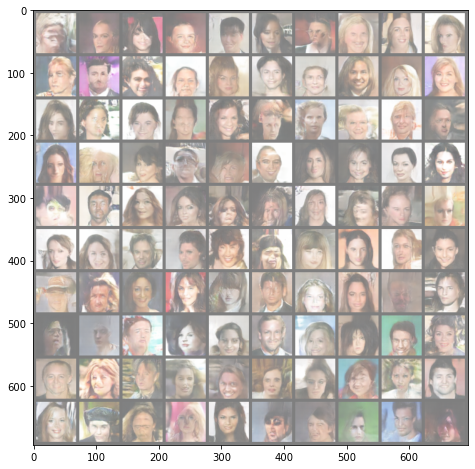

Epoch [13 / 15] average loss generator vs. discrim.: 3476.422562 vs. 592.565846

Batch: 50 Generator Loss: 2.1288900113105775 Discriminator Loss: 0.36947980999946595
Batch: 100 Generator Loss: 2.2011269760131835 Discriminator Loss: 0.35858221650123595
Batch: 150 Generator Loss: 2.244755691289902 Discriminator Loss: 0.3839129763841629
Batch: 200 Generator Loss: 2.293548719882965 Discriminator Loss: 0.37289719343185423
Batch: 250 Generator Loss: 2.2520120191574096 Discriminator Loss: 0.36231562405824663
Batch: 300 Generator Loss: 2.0847227001190185 Discriminator Loss: 0.3857455345988274
Batch: 350 Generator Loss: 2.1241317653656004 Discriminator Loss: 0.38997609078884127
Batch: 400 Generator Loss: 2.203493523597717 Discriminator Loss: 0.36302222579717636
Batch: 450 Generator Loss: 2.2036980068683625 Discriminator Loss: 0.386810177564621
Batch: 500 Generator Loss: 2.255199987888336 Discriminator Loss: 0.3673038551211357


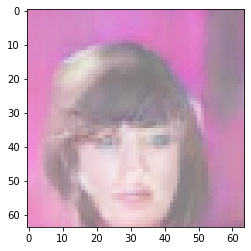

Batch: 550 Generator Loss: 2.254658513069153 Discriminator Loss: 0.34411654382944107
Batch: 600 Generator Loss: 2.214848597049713 Discriminator Loss: 0.3722987246513367
Batch: 650 Generator Loss: 2.1683065843582154 Discriminator Loss: 0.36550438225269316
Batch: 700 Generator Loss: 2.143158540725708 Discriminator Loss: 0.375553839802742
Batch: 750 Generator Loss: 2.233471233844757 Discriminator Loss: 0.3613175117969513
Batch: 800 Generator Loss: 2.2374916434288026 Discriminator Loss: 0.36504604399204255
Batch: 850 Generator Loss: 2.1848658227920534 Discriminator Loss: 0.3752273565530777
Batch: 900 Generator Loss: 2.281980984210968 Discriminator Loss: 0.37514569610357285
Batch: 950 Generator Loss: 2.208061056137085 Discriminator Loss: 0.35705013304948807
Batch: 1000 Generator Loss: 2.1654387807846067 Discriminator Loss: 0.3763878017663956


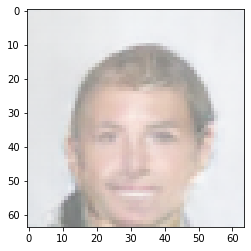

Batch: 1050 Generator Loss: 2.1848656511306763 Discriminator Loss: 0.3703363561630249
Batch: 1100 Generator Loss: 2.18754474401474 Discriminator Loss: 0.5542973762750626
Batch: 1150 Generator Loss: 2.082348837852478 Discriminator Loss: 0.38674440324306486
Batch: 1200 Generator Loss: 2.1524380159378054 Discriminator Loss: 0.38552289724349975
Batch: 1250 Generator Loss: 2.114369626045227 Discriminator Loss: 0.3786861377954483
Batch: 1300 Generator Loss: 2.1937851428985597 Discriminator Loss: 0.3598081335425377
Batch: 1350 Generator Loss: 2.1536815214157103 Discriminator Loss: 0.3685692876577377
Batch: 1400 Generator Loss: 2.1097648191452025 Discriminator Loss: 0.36107398867607116
Batch: 1450 Generator Loss: 2.2352725863456726 Discriminator Loss: 0.3616659614443779
Batch: 1500 Generator Loss: 2.148330413103104 Discriminator Loss: 0.3817672300338745


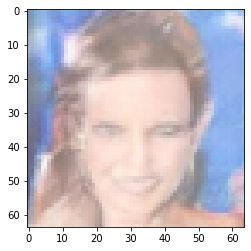

Batch: 1550 Generator Loss: 2.1263232231140137 Discriminator Loss: 0.3846393966674805


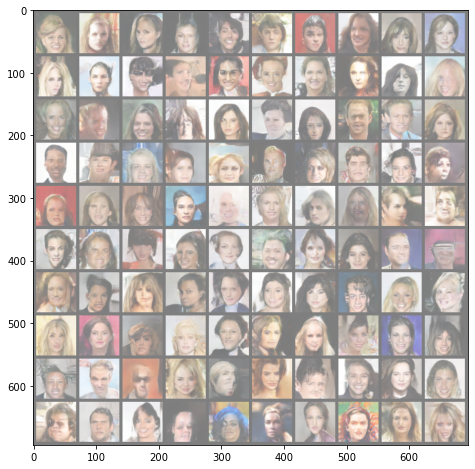

Epoch [14 / 15] average loss generator vs. discrim.: 3460.123073 vs. 596.525300

Batch: 50 Generator Loss: 2.185949139595032 Discriminator Loss: 0.3663091698288918
Batch: 100 Generator Loss: 2.2553319919109343 Discriminator Loss: 0.38277792870998384
Batch: 150 Generator Loss: 2.1432332849502562 Discriminator Loss: 0.35574263602495193
Batch: 200 Generator Loss: 2.193149666786194 Discriminator Loss: 0.37206855058670046
Batch: 250 Generator Loss: 2.254710689783096 Discriminator Loss: 0.3681337079405785
Batch: 300 Generator Loss: 2.213850526809692 Discriminator Loss: 0.3815923464298248
Batch: 350 Generator Loss: 2.2192061495780946 Discriminator Loss: 0.3508421975374222
Batch: 400 Generator Loss: 2.20573436498642 Discriminator Loss: 0.3657305833697319
Batch: 450 Generator Loss: 2.2018358945846557 Discriminator Loss: 0.37371366113424304
Batch: 500 Generator Loss: 2.2254392957687377 Discriminator Loss: 0.345196832716465


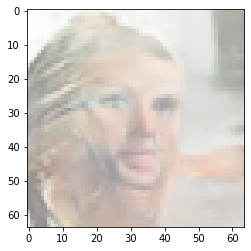

Batch: 550 Generator Loss: 2.293635950088501 Discriminator Loss: 0.36639117062091825
Batch: 600 Generator Loss: 2.2342952036857606 Discriminator Loss: 0.34913193076848986
Batch: 650 Generator Loss: 2.207813227176666 Discriminator Loss: 0.36512121200561526
Batch: 700 Generator Loss: 2.275764012336731 Discriminator Loss: 0.36716624051332475
Batch: 750 Generator Loss: 2.2427857899665833 Discriminator Loss: 0.3449717238545418
Batch: 800 Generator Loss: 2.153407735824585 Discriminator Loss: 0.3522747847437859
Batch: 850 Generator Loss: 2.252016122341156 Discriminator Loss: 0.39400217920541764
Batch: 900 Generator Loss: 2.2668109488487245 Discriminator Loss: 0.36140680372714995
Batch: 950 Generator Loss: 2.2107165670394897 Discriminator Loss: 0.47320398688316345
Batch: 1000 Generator Loss: 2.1951936435699464 Discriminator Loss: 0.3532304599881172


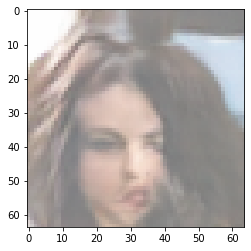

Batch: 1050 Generator Loss: 2.2066305232048036 Discriminator Loss: 0.3743104562163353
Batch: 1100 Generator Loss: 2.1179647982120513 Discriminator Loss: 0.3826038259267807
Batch: 1150 Generator Loss: 2.1629606795310976 Discriminator Loss: 0.4792210239171982
Batch: 1200 Generator Loss: 2.1733801198005676 Discriminator Loss: 0.3499747675657272
Batch: 1250 Generator Loss: 2.1447017693519594 Discriminator Loss: 0.37072982132434845
Batch: 1300 Generator Loss: 2.13072514295578 Discriminator Loss: 0.36387078851461413
Batch: 1350 Generator Loss: 2.1882424211502074 Discriminator Loss: 0.3704706710577011
Batch: 1400 Generator Loss: 2.141170418262482 Discriminator Loss: 0.3717932331562042
Batch: 1450 Generator Loss: 2.223662896156311 Discriminator Loss: 0.35101227641105653
Batch: 1500 Generator Loss: 2.140773124694824 Discriminator Loss: 0.35578155517578125


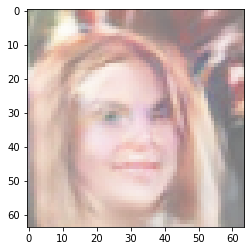

Batch: 1550 Generator Loss: 2.1965932035446167 Discriminator Loss: 0.3570720994472504


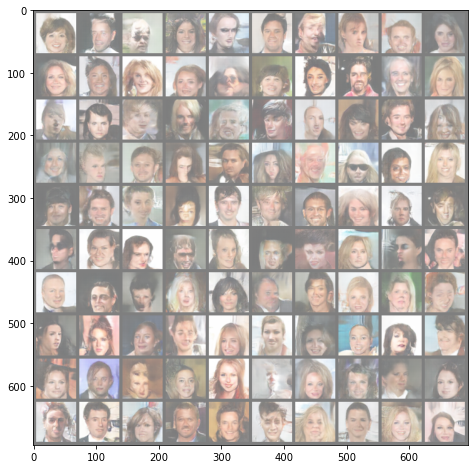

Epoch [15 / 15] average loss generator vs. discrim.: 3485.106638 vs. 589.432422



In [10]:
learning_rate = 0.0001
num_epochs = 15

gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    running_loss_1 = 0.0
    running_loss_2 = 0.0

    generator.train()
    discriminator.train()
    
    for i,(image_batch) in enumerate(train_dataloader):
        
        generator.train()
        discriminator.train()
        
        image_batch = image_batch.to(device)
        
        k = np.random.uniform(0.05,0.15)
        
        label_real = torch.ones(image_batch.size(0), device=device)*(1-k)
        label_fake = torch.ones(image_batch.size(0), device=device)*k

        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        running_loss_1 += gen_loss.item()
        running_loss_2 += disc_loss.item()

        if i%50 == 49:
          print("Batch:",i+1,"Generator Loss:",running_loss_1/50,"Discriminator Loss:",running_loss_2/50)
          running_loss_1 = 0.0
          running_loss_2 = 0.0
        
        if i%500 == 499:
            generator.eval()
            z = torch.randn(1, 100, 1, 1, device=device)
            epoch_pred = generator(z)
            img = epoch_pred.view(3,64, 64).detach().cpu().numpy().transpose(1,2,0)
            plt.imshow((img+1.)/2.)
            plt.show()
        
    with torch.no_grad():
        latent = torch.randn(128, 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        fake_image_batch = fake_image_batch.cpu()
        
        fig, ax = plt.subplots(figsize=(8, 8))
        show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
        plt.show()
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %(epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))
    print("")

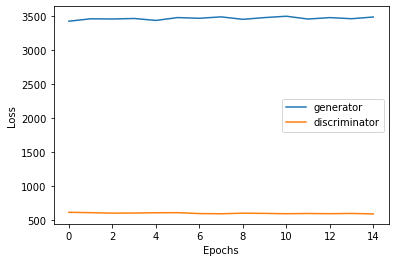

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

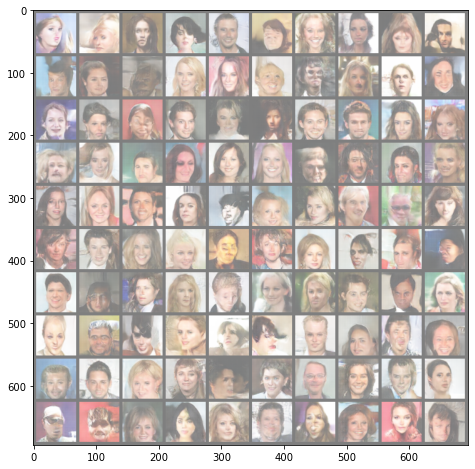

In [15]:
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

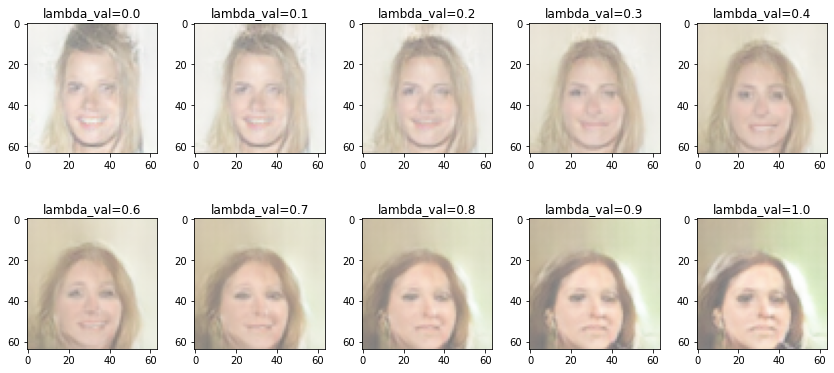

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    image = inter_image.numpy()
    image = image.reshape(3,64,64)
   
    axs[ind].imshow(np.transpose(image, (1, 2, 0)))
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()